In [1]:
import os
import sys
sys.path.append('../python_scripts/')
import datasets, train, baseline, analysis
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Complete notebook to present data for IDVOR
Compiled and fixed by Jason, base code by Sam

## Baseline Variability
We should quantify baseline variability before how measuring how much variability comes from randomization seed and dataset shuffling

First, we'll train an instance of All-CNN-C on CIFAR10. 

In [2]:
# Make GPU training deterministic
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(0)

# Set seeds
weightSeed = 43
shuffleSeed = 99

We preprocess the images the same way that the original authors do, global contrast normalization and whitened with ZCA. During training, we augment the data the same way: horizontal flipping and random translation (5 pixels in any direction). 

In [3]:
modelPath = '../outputs/masterOutput/baseline/w'+str(weightSeed)+'s'+str(shuffleSeed)+'.pb'

if os.path.exists(modelPath): # The model already exists, load it.
    print('Loading model')
    model = tf.keras.models.load_model(modelPath)
else: # Train new model
    print('Training new model')
    trainData, testData = datasets.make_train_data(shuffle_seed=shuffleSeed, augment=True)
    x_predict, y_predict = datasets.make_predict_data(testData)

    model = train.init_all_cnn_c(seed=weightSeed)

    # Set flag to true if converges to local min
    abort = False
    history = model.fit(
        x=trainData, 
        epochs=350, 
        validation_data=testData.prefetch(tf.data.experimental.AUTOTUNE).batch(128), 
        callbacks=[train.LR_Callback, train.Early_Abort_Callback()])

    if not abort:
        tf.keras.models.save_model(model, modelPath)
    else:
        raise ValueException('Model hit local minimum!')

Loading model


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       3

All-CNN-C is a relatively small and efficient network that handles CIFAR10 relatively well. It's a good test case for our purposes in this project and we are following Kriegeskorte on this one. Something that we improve over previous work is that we explicitly train with augmentation. Notably the augmentation only applies translation and flip. This might matter later. Another note here is that perhaps we should be repeating this analysis with multiple models as we do know models differ between instances.

We take the output from layer index 12 to do our RSAs, this is the output of the global average pooling layer. Our test set is the 1000 test images of CIFAR10. The transformations we use to measure baseline variability are flip, translation, zoom, and color shift. We'll look at each in turn.

Flip is relatively simple. Since there's only one variation, it's a simple point estimate.

In [5]:
modelOutputIndex = 12

In [6]:
reflectRSAPath = '../outputs/masterOutput/baseline/reflectRSA.npy'
if os.path.exists(reflectRSAPath):
    print('Loading reflect RSA results')
    reflectRSA = np.load(reflectRSAPath)
else:
    print('Doing reflect RSA')
    reflectRSA = baseline.transform_baseline('reflect', 
                                             model, modelOutputIndex,
                                             analysis.do_rsa,
                                             analysis.preprocess_rsa)
    np.save(reflectRSAPath, reflectRSA)

print(f'Reflect RSA value: {reflectRSA[0]}')

Loading reflect RSA results
Reflect RSA value: 0.9436638227223328


As a reminder, this RSA is produced with a Spearman rank correlation with a range between [-1, 1]. A note here is that there might be "RSA best practices" that tells us that we should be doing a Fisher Z transform somewhere along the way. It is entirely expected that this value is relatively high as the model is literally trained on augmentation of this exact type. It is suprising that this isn't basically 1 though.

In [7]:
transRSAPath = '../outputs/masterOutput/baseline/transRSAPath.npy'
if os.path.exists(transRSAPath):
    print('Loading translation RSA results')
    transRSA = np.load(transRSAPath)
else:
    print('Doing translation RSA')
    transRSA = baseline.transform_baseline('shift', 
                                          model, modelOutputIndex,
                                          analysis.do_rsa,
                                          analysis.preprocess_rsa)
    np.save(transRSAPath, transRSA)
    
# Add mean column
transRSA = np.nan_to_num(transRSA)
transMean = np.expand_dims(np.mean(transRSA, axis=1), 1)
transRSA = np.hstack((transRSA, transMean))

Loading translation RSA results


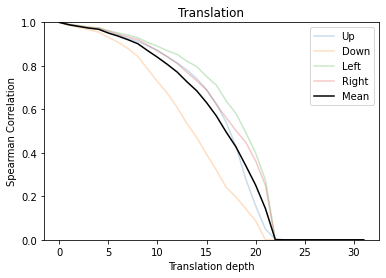

In [8]:
plt.plot(transRSA[:,0], alpha = 0.25)
plt.plot(transRSA[:,1], alpha = 0.25)
plt.plot(transRSA[:,2], alpha = 0.25)
plt.plot(transRSA[:,3], alpha = 0.25)
plt.plot(transRSA[:,4], 'black', alpha = 1)
plt.xlabel('Translation depth')
plt.ylabel('Spearman Correlation')
plt.ylim(0, 1)
plt.title('Translation')
plt.legend(['Up', 'Down', 'Left', 'Right', 'Mean'])
plt.show()

In [9]:
zoomRSAPath = '../outputs/masterOutput/baseline/zoomRSAPath.npy'
if os.path.exists(zoomRSAPath):
    print('Loading zoom RSA results')
    zoomRSA = np.load(zoomRSAPath)
else:
    print('Doing zoom RSA')
    zoomRSA = baseline.transform_baseline('zoom', 
                                          model, modelOutputIndex,
                                          analysis.do_rsa,
                                          analysis.preprocess_rsa)
    np.save(zoomRSAPath, zoomRSA)
    
zoomRSA = np.nan_to_num(zoomRSA)

Loading zoom RSA results


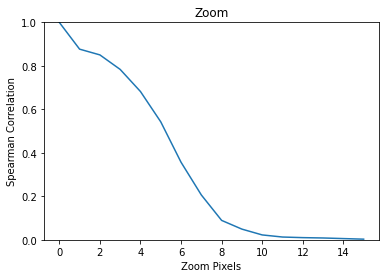

In [10]:
plt.plot(zoomRSA)
plt.xlabel('Zoom Pixels')
plt.ylabel('Spearman Correlation')
plt.ylim(0, 1)
plt.title('Zoom')
plt.show()

In [11]:
colorRSAPath = '../outputs/masterOutput/baseline/colorRSAPath.npy'
if os.path.exists(colorRSAPath):
    print('Loading color RSA results')
    colorRSA = np.load(colorRSAPath)
else:
    print('Doing color RSA')
    colorRSA = baseline.transform_baseline('color', 
                                           model, modelOutputIndex,
                                           analysis.do_rsa,
                                           analysis.preprocess_rsa)
    np.save(colorRSAPath, colorRSA)
    
colorRSA = np.nan_to_num(colorRSA)

Loading color RSA results


Show examples of color.

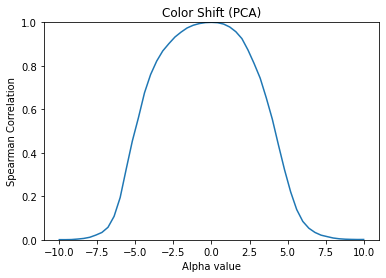

In [12]:
plt.plot(np.linspace(-10, 10, 51), colorRSA)
plt.xlabel('Alpha value')
plt.ylabel('Spearman Correlation')
plt.ylim(0, 1)
plt.title('Color Shift (PCA)')
plt.show()

Now we repeat with PWCCA.

In [13]:
reflectPWCCAPath = '../outputs/masterOutput/baseline/reflectPWCCA.npy'
if os.path.exists(reflectPWCCAPath):
    print('Loading reflect PWCCA results')
    reflectPWCCA = np.load(reflectPWCCAPath)
else:
    print('Doing reflect RSA')
    reflectPWCCA = baseline.transform_baseline('reflect', 
                                               model, modelOutputIndex,
                                               analysis.do_pwcca,
                                               analysis.preprocess_pwcca)
    np.save(reflectPWCCAPath, reflectPWCCA)

print(f'Reflect PWCCA value: {reflectPWCCA[0]}')

Loading reflect PWCCA results
Reflect PWCCA value: 0.9697475991172684


In [14]:
transPWCCAPath = '../outputs/masterOutput/baseline/transPWCCAPath.npy'
if os.path.exists(transPWCCAPath):
    print('Loading translation PWCCA results')
    transPWCCA = np.load(transPWCCAPath)
else:
    print('Doing translation PWCCA')
    transPWCCA = baseline.transform_baseline('shift', 
                                             model, modelOutputIndex,
                                             analysis.do_pwcca,
                                             analysis.preprocess_pwcca)
    np.save(transPWCCAPath, transPWCCA)
    
# Add mean column
transPWCCA = np.nan_to_num(transPWCCA)
transMean = np.expand_dims(np.mean(transPWCCA, axis=1), 1)
transPWCCA = np.hstack((transPWCCA, transMean))

Loading translation PWCCA results


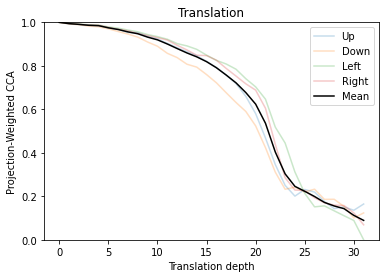

In [15]:
plt.plot(transPWCCA[:,0], alpha = 0.25)
plt.plot(transPWCCA[:,1], alpha = 0.25)
plt.plot(transPWCCA[:,2], alpha = 0.25)
plt.plot(transPWCCA[:,3], alpha = 0.25)
plt.plot(transPWCCA[:,4], 'black', alpha = 1)
plt.xlabel('Translation depth')
plt.ylabel('Projection-Weighted CCA')
plt.ylim(0, 1)
plt.title('Translation')
plt.legend(['Up', 'Down', 'Left', 'Right', 'Mean'])
plt.show()

In [16]:
zoomPWCCAPath = '../outputs/masterOutput/baseline/zoomPWCCAPath.npy'
if os.path.exists(zoomPWCCAPath):
    print('Loading zoom PWCCA results')
    zoomPWCCA = np.load(zoomPWCCAPath)
else:
    print('Doing zoom PWCCA')
    zoomPWCCA = baseline.transform_baseline('zoom', 
                                            model, modelOutputIndex,
                                            analysis.do_pwcca,
                                            analysis.preprocess_pwcca)
    np.save(zoomPWCCAPath, zoomPWCCA)
    
zoomPWCCA = np.nan_to_num(zoomPWCCA)

Loading zoom PWCCA results


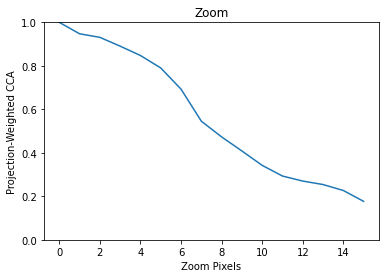

In [17]:
plt.plot(zoomPWCCA)
plt.xlabel('Zoom Pixels')
plt.ylabel('Projection-Weighted CCA')
plt.ylim(0, 1)
plt.title('Zoom')
plt.show()

In [18]:
colorPWCCAPath = '../outputs/masterOutput/baseline/colorPWCCAPath.npy'
if os.path.exists(colorPWCCAPath):
    print('Loading color PWCCA results')
    colorPWCCA = np.load(colorPWCCAPath)
else:
    print('Doing color PWCCA')
    colorPWCCA = baseline.transform_baseline('color', 
                                           model, modelOutputIndex,
                                           analysis.do_pwcca,
                                           analysis.preprocess_pwcca)
    np.save(colorPWCCAPath, colorPWCCA)
    
colorPWCAA = np.nan_to_num(colorPWCCA)

Loading color PWCCA results


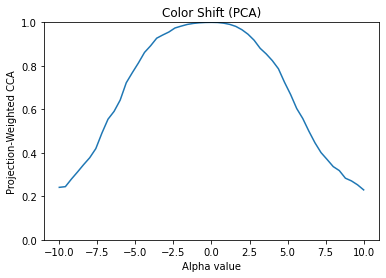

In [19]:
plt.plot(np.linspace(-10, 10, 51), colorPWCCA)
plt.xlabel('Alpha value')
plt.ylabel('Projection-Weighted CCA')
plt.ylim(0, 1)
plt.title('Color Shift (PCA)')
plt.show()

# Differences

In [20]:
reflectPWCCA - reflectRSA

array([0.02608378])

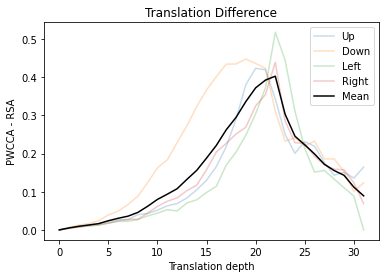

In [24]:
tmp = transPWCCA - transRSA
plt.plot(tmp[:,0], alpha = 0.25)
plt.plot(tmp[:,1], alpha = 0.25)
plt.plot(tmp[:,2], alpha = 0.25)
plt.plot(tmp[:,3], alpha = 0.25)
plt.plot(tmp[:,4], 'black', alpha = 1)
plt.xlabel('Translation depth')
plt.ylabel('PWCCA - RSA')
plt.title('Translation Difference')
plt.legend(['Up', 'Down', 'Left', 'Right', 'Mean'])
plt.show()

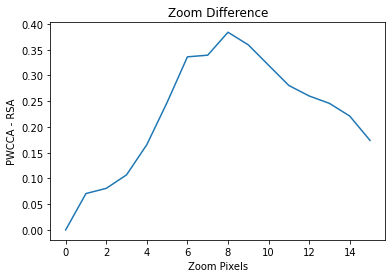

In [26]:
tmp = zoomPWCCA - zoomRSA
plt.plot(tmp)
plt.xlabel('Zoom Pixels')
plt.ylabel('PWCCA - RSA')
plt.title('Zoom Difference')
plt.show()

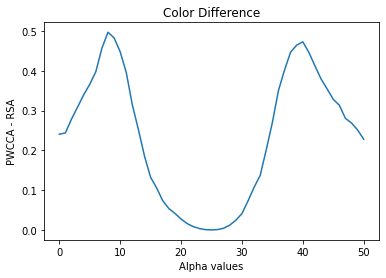

In [27]:
tmp = colorPWCCA - colorRSA
plt.plot(tmp)
plt.xlabel('Alpha values')
plt.ylabel('PWCCA - RSA')
plt.title('Color Difference')
plt.show()

"Bootstrap" representations vs transformed simulation testing to compare various metrics.